matplotlib 图像行内显示： `%matplotlib inline`

通过 PIL 加载图像：`Image.open('img/cnn_sample_test.jpg')`

图像转 numpy array： `numpy.asarray(img, dtype='float32')`

numpy array 转 PIL 图像： `Image.fromarray(img[:, :, :], 'RGB')`，第一个参数是 array ，第二个参数是图像的模式，灰度图像为 L，彩色图像为 RGB

PIL 多图像拼接显示：
```
gs1 = gridspec.GridSpec(3, 5)
for i in range(3):
    plt.subplot(gs1[i, 0]); plt.axis('off'); plt.imshow(img[:, :, :])
    plt.subplot(gs1[i, 1]); plt.axis('off'); plt.imshow(conv_op[0, :, :, i])
    plt.subplot(gs1[i, 2]); plt.axis('off'); plt.imshow(sigmoid_op[0, :, :, i])
    plt.subplot(gs1[i, 3]); plt.axis('off'); plt.imshow(avg_pool_op[0, :, :, i])
    plt.subplot(gs1[i, 4]); plt.axis('off'); plt.imshow(max_pool_op[0, :, :, i])
plt.show()
```


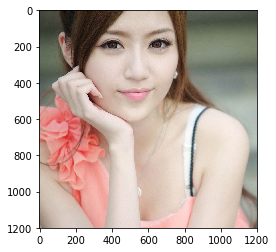

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from PIL import Image
import numpy

%matplotlib inline

img = Image.open('img/cnn_sample_test.jpg')
# img = img.resize((256, 256))
plt.imshow(img)


In [2]:
def show_image_ops_gray(img, conv_op, sigmoid_op, avg_pool_op, max_pool_op):
    gs1 = gridspec.GridSpec(1, 5)
    plt.subplot(gs1[0, 0]); plt.axis('off'); plt.imshow(img[:, :], cmap=plt.get_cmap('gray'))
    plt.subplot(gs1[0, 1]); plt.axis('off'); plt.imshow(conv_op[0, :, :, 0], cmap=plt.get_cmap('gray'))
    plt.subplot(gs1[0, 2]); plt.axis('off'); plt.imshow(sigmoid_op[0, :, :, 0], cmap=plt.get_cmap('gray'))
    plt.subplot(gs1[0, 3]); plt.axis('off'); plt.imshow(avg_pool_op[0, :, :, 0], cmap=plt.get_cmap('gray'))
    plt.subplot(gs1[0, 4]); plt.axis('off'); plt.imshow(max_pool_op[0, :, :, 0], cmap=plt.get_cmap('gray'))
    plt.show()


def show_image_ops_rgb(img, conv_op, sigmoid_op, avg_pool_op, max_pool_op):
    gs1 = gridspec.GridSpec(3, 5)
    plt.subplot(gs1[0, 0]); plt.axis('off'); plt.imshow(img[:, :, :])
    for i in range(3):
        plt.subplot(gs1[i, 1]); plt.axis('off'); plt.imshow(conv_op[0, :, :, i])
        plt.subplot(gs1[i, 2]); plt.axis('off'); plt.imshow(sigmoid_op[0, :, :, i])
        plt.subplot(gs1[i, 3]); plt.axis('off'); plt.imshow(avg_pool_op[0, :, :, i])
        plt.subplot(gs1[i, 4]); plt.axis('off'); plt.imshow(max_pool_op[0, :, :, i])
    plt.show()

def show_shapes(img, conv_op, sigmoid_op, avg_pool_op, max_pool_op):
    print("""
        image filters (shape {})
        conv_op filters (shape {})
        sigmoid_op filters (shape {})
        avg_pool_op filters (shape {})
        max_pool_op filters (shape {})
        """.format(
            img.shape, conv_op.shape, sigmoid_op.shape, avg_pool_op.shape, max_pool_op.shape))

In [3]:
def convolve(img, kernel, strides=[1, 3, 3, 1], pooling=[1, 3, 3, 1], padding='SAME', rgb=True):
    with tf.Graph().as_default():
        num_maps = 3
        if not rgb:
            num_maps = 1  # set number of maps to 1
            img = img.convert('L', (0.2989, 0.5870, 0.1140, 0))  # convert to gray scale


        # reshape image to have a leading 1 dimension
        img = numpy.asarray(img, dtype='float32') / 256.
        img_shape = img.shape
        img_reshaped = img.reshape(1, img_shape[0], img_shape[1], num_maps)
        x = tf.placeholder('float32', [1, None, None, num_maps])
        w = tf.get_variable('w', initializer=tf.to_float(kernel))
        b = tf.get_variable('b', [w.shape[3]], initializer=tf.constant_initializer(0.1))

        # operations
        conv = tf.nn.conv2d(x, w, strides=strides, padding=padding)
        sig = tf.nn.relu(conv)
        max_pool = tf.nn.max_pool(sig, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding=padding)
        avg_pool = tf.nn.avg_pool(sig, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding=padding)

        init = tf.initialize_all_variables()
        with tf.Session() as session:
            session.run(init)
            conv_op, sigmoid_op, avg_pool_op, max_pool_op = session.run([conv, sig, avg_pool, max_pool],
                                                                        feed_dict={x: img_reshaped})

        show_shapes(img, conv_op, sigmoid_op, avg_pool_op, max_pool_op)
        if rgb:
            show_image_ops_rgb(img, conv_op, sigmoid_op, avg_pool_op, max_pool_op)
        else:
            show_image_ops_gray(img, conv_op, sigmoid_op, avg_pool_op, max_pool_op)
    img = (max_pool_op * 256).astype(int)
    img =  Image.fromarray(img[0, :, :, :] if rgb else np.array([img[0, :, :, 0], img[0, :, :, 0], img[0, :, :, 0]]), 'RGB')
    return img

Instructions for updating:
Use `tf.global_variables_initializer` instead.

        image filters (shape (1200, 1200))
        conv_op filters (shape (1, 400, 400, 1))
        sigmoid_op filters (shape (1, 400, 400, 1))
        avg_pool_op filters (shape (1, 134, 134, 1))
        max_pool_op filters (shape (1, 134, 134, 1))
        


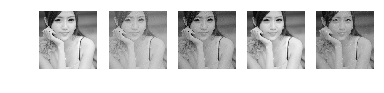


        image filters (shape (1200, 1200, 3))
        conv_op filters (shape (1, 400, 400, 3))
        sigmoid_op filters (shape (1, 400, 400, 3))
        avg_pool_op filters (shape (1, 134, 134, 3))
        max_pool_op filters (shape (1, 134, 134, 3))
        


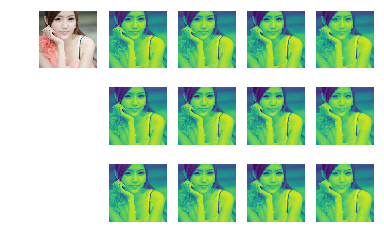

In [4]:
# sharpen
a = np.zeros([3, 3, 1, 1])
a[1, 1, :, :] = 5
a[0, 1, :, :] = -1
a[1, 0, :, :] = -1
a[2, 1, :, :] = -1
a[1, 2, :, :] = -1
img2 = convolve(img, a, rgb=False)
# convolve2(img2, a, rgb=False)

a = np.zeros([3, 3, 3, 3])
a[1, 1, :, :] = 0.25
a[0, 1, :, :] = 0.125
a[1, 0, :, :] = 0.125
a[2, 1, :, :] = 0.125
a[1, 2, :, :] = 0.125
a[0, 0, :, :] = 0.0625
a[0, 2, :, :] = 0.0625
a[2, 0, :, :] = 0.0625
a[2, 2, :, :] = 0.0625
img2 = convolve(img, a)
# convolve2(img2, a)